In [1]:
import warnings
import torch
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from types import SimpleNamespace
from datasets import load_dataset
from timm.optim import Mars
from timm.models.layers import drop_path
from torchvision.transforms.v2 import (
    Compose, RandAugment, RandomErasing, Resize, RandomCrop, CenterCrop, 
    PILToTensor, ToDtype, MixUp, CutMix, ToPILImage, InterpolationMode
)
from fastprogress.fastprogress import master_bar, progress_bar
import copy
import PIL.Image

/home/dgj335/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
torch.set_float32_matmul_precision('highest')
device = "cuda:0"
dataset_train = load_dataset('timm/imagenet-1k-wds', split='train')
dataset_valid = load_dataset('timm/imagenet-1k-wds', split='validation')

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/64 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/292 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/64 [00:00<?, ?it/s]

In [3]:
config = SimpleNamespace()
config.epochs = 48
config.batch_size = 128
config.steps_per_epoch = dataset_train.num_rows // config.batch_size
config.total_steps = config.epochs * config.steps_per_epoch

config.num_workers = 32
config.grad_accum_steps = 1
config.max_lr = 5e-4 * (config.batch_size/128)
config.min_lr = config.max_lr/1e6;
config.lr_pow = 6; assert (config.lr_pow/2)%1 == 0

config.weight_decay = 0.1
config.no_wd_keys = ['norm', 'bias']

config.randaug_n = 2
config.randaug_m = 5
config.randerase = 0.2

config.progressive_sizes = 6*[96] + [128,160,192] + 3*[224]

config.mixup_alpha = 1.0

config.label_smoothing = 0.1

config.mesa = True
config.ema_decay = 0.9999
config.mesa_ratio = 2.0
config.mesa_start = 0.25

config.drop_path = 0.1

config.channels=3
config.classifier_num_classes=1000

config.log_filename = 'log_cuda_1'

In [4]:
from timm.models.efficientvit_mit import EfficientVitLarge, GELUTanh

class GroupNorm8(torch.nn.Module):
    def __init__(self, num_features, eps=1e-7, affine=True):
        super().__init__()
        self.groupnorm = torch.nn.GroupNorm(num_groups=8,
                                      num_channels=num_features,
                                      eps=eps,
                                      affine=affine)
    def forward(self, x):
        return self.groupnorm(x)

model = EfficientVitLarge(
    in_chans=config.channels,
    widths=(32, 64, 128, 256, 512),
    depths=(1, 1, 1, 6, 6),
    head_dim=32,
    norm_layer=GroupNorm8,
    act_layer=GELUTanh,
    global_pool='avg',
    head_widths=(3072, 3200),
    drop_rate=0.0,
    num_classes=config.classifier_num_classes
)
model.head.in_conv.norm = torch.nn.GroupNorm(
    num_groups=8,
    num_channels=model.head.in_conv.norm.num_features,
    affine=model.head.in_conv.norm.affine,
    eps=model.head.in_conv.norm.eps
)

model.to(device)

print(sum(p.numel() for p in model.parameters())/1e6)
for name, module in model.named_children():
    print(f"{sum(p.numel() for p in module.parameters())/1e6} \t {name}")

52.654088
0.019488 	 stem
38.017792 	 stages
14.616808 	 head


In [5]:
def count_sub_blocks(model):
    """
    Count the total # of sub-blocks across all stages:
      - Each normal `ResidualBlock` counts as 1
      - Each `EfficientVitBlock` has two sub-blocks (`context_module`, `local_module`).
    """
    n_sub = 0
    for stage in model.stages:               # model.stages is e.g. [stage0, stage1, ...]
        for block in stage.blocks:           # each stage.blocks is a list/Sequential
            # If it's a vanilla residual block
            if hasattr(block, 'main') and hasattr(block, 'shortcut'):
                n_sub += 1
            # If it's the bigger "ViT block"
            elif hasattr(block, 'context_module') and hasattr(block, 'local_module'):
                # each has a `main` and `shortcut` as well
                n_sub += 2
            else:
                # fallback or unknown block type
                n_sub += 1
    return n_sub
    
def get_drop_prob(i, skip, n_sub_blocks, base_drop):
    """
    Linearly increase drop probability from 0 to `base_drop`
    after skipping the first `skip` sub-blocks.
    
    i is 1-based index into the sub-blocks.
    """
    if i <= skip:
        return 0.0
    # fraction of how "deep" we are, ignoring skip
    ratio = (i - skip) / max(1, (n_sub_blocks - skip))
    return base_drop * ratio
    
def forward_resblock_sd(x, block, drop_prob, training=True):
    """
    Forward pass for a single residual block with drop-path on the 'main' branch.
    
    block is something like:
        block.pre_norm, block.main, block.shortcut
    """
    # get the main branch output
    out = block.pre_norm(x)
    out = block.main(out)
    
    # apply drop path if training and drop_prob > 0
    if training and drop_prob > 0:
        out = drop_path(out, drop_prob, training=training)

    # add shortcut if present
    if block.shortcut is not None:
        out = out + block.shortcut(x)
    return out
def forward_sd(x, model, base_drop=0.1, skip=2, training=True):
    """
    Custom forward pass that applies linearly decayed DropPath
    on each residual-like sub-block. 
    We skip the first 'skip' sub-blocks from any drop, 
    then ramp from 0..base_drop up to the final sub-block.

    Use this function only in training. At inference, just do model(x).
    """
    n_sub_blocks = count_sub_blocks(model)  # total sub-blocks
    sub_block_idx = 1                       # 1-based index

    # --- stem ---
    x = model.stem(x)

    # --- each stage ---
    for stage in model.stages:
        # stage.blocks is a list/Sequential
        for block in stage.blocks:

            # 1) If it's a standard ResidualBlock or FusedMBConv...
            if hasattr(block, 'main') and hasattr(block, 'shortcut') and not hasattr(block, 'context_module'):
                # compute drop prob for sub_block_idx
                dp = get_drop_prob(sub_block_idx, skip, n_sub_blocks, base_drop)
                x = forward_resblock_sd(x, block, dp, training=training)
                sub_block_idx += 1

            # 2) If it's an EfficientVitBlock (which has 2 sub-blocks)
            elif hasattr(block, 'context_module') and hasattr(block, 'local_module'):
                # (a) context_module
                dp_ctx = get_drop_prob(sub_block_idx, skip, n_sub_blocks, base_drop)
                x = forward_resblock_sd(x, block.context_module, dp_ctx, training=training)
                sub_block_idx += 1
                
                # (b) local_module
                dp_loc = get_drop_prob(sub_block_idx, skip, n_sub_blocks, base_drop)
                x = forward_resblock_sd(x, block.local_module, dp_loc, training=training)
                sub_block_idx += 1

            # 3) Fallback for anything else not matching the above
            else:
                x = block(x)
                # optionally sub_block_idx += 1 if you want to count it

    # --- head ---
    x = model.forward_head(x)
    return x


In [6]:
param_groups = []
for name, p in model.named_parameters():
    if p.requires_grad:
        use_wd = True
        for kw in config.no_wd_keys:
            if kw in name.lower():
                use_wd = False
                break
        wd_val = config.weight_decay if use_wd else 0.0
        param_groups.append({'params': [p], 'weight_decay': wd_val})

optimizer = Mars(param_groups, lr=1.0, weight_decay=0.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

/home/dgj335/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


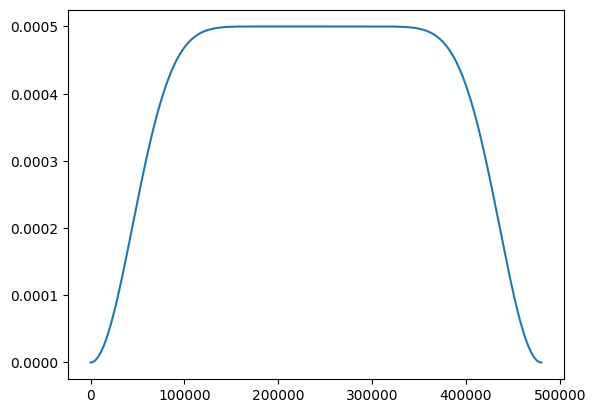

In [10]:
# learning_rates = [optimizer.param_groups[0]['lr']]
# for i_step in range(config.total_steps):
#     schedule.step()
#     learning_rates.append(optimizer.param_groups[0]['lr'])
# plt.plot(learning_rates)

In [7]:
class EMAHelper:
    def __init__(self, model, decay=0.9999):
        self.decay = decay
        self.teacher = copy.deepcopy(model)
        for p in self.teacher.parameters():
            p.requires_grad_(False)

    def update(self, student):
        with torch.no_grad():
            d = self.decay
            for tparam, sparam in zip(self.teacher.parameters(), student.parameters()):
                tparam.copy_(tparam * d + sparam * (1 - d))
    
    def forward(self, x):
        return self.teacher(x)

In [8]:
mixup_tfm = MixUp(alpha=config.mixup_alpha, num_classes=config.classifier_num_classes)

def get_epoch_size(epoch):
    stage_len = config.epochs // len(config.progressive_sizes)
    idx = min(epoch // stage_len, len(config.progressive_sizes)-1)
    return config.progressive_sizes[idx]

def build_train_prebatch_transform(epoch):
    interp = InterpolationMode.LANCZOS
    return Compose([
        Resize(get_epoch_size(epoch), interpolation=interp),
        RandomCrop(get_epoch_size(epoch), padding=get_epoch_size(epoch)//8, padding_mode='reflect'),
        PILToTensor(),
        ToDtype(torch.float32,scale=False),
        lambda x: x/127.5 - 1.0,
    ])

def build_valid_transform():
    return Compose([
        Resize(config.progressive_sizes[-1], interpolation=InterpolationMode.LANCZOS),
        CenterCrop(config.progressive_sizes[-1]),
        PILToTensor(),
        ToDtype(torch.float32,scale=False),
        lambda x: x/127.5 - 1.0,
    ])
    
def train_collate_fn(batch, epoch):
    transform = build_train_prebatch_transform(epoch)
    x_list, y_list = [], []
    for sample in batch:
        img = sample['jpg'].convert("RGB")
        cls_ = sample['cls']
        x_ = transform(img)
        x_list.append(x_)
        y_list.append(cls_)
    x = torch.stack(x_list, dim=0)
    y = torch.tensor(y_list, dtype=torch.long)
    return x, torch.nn.functional.one_hot(y, num_classes=config.classifier_num_classes)

def valid_collate_fn(batch):
    transform = build_valid_transform()
    x_list, y_list = [], []
    for sample in batch:
        img = sample['jpg'].convert("RGB")
        x_ = transform(img)
        y_ = sample['cls']
        x_list.append(x_)
        y_list.append(y_)
    x = torch.stack(x_list, dim=0)
    y = torch.tensor(y_list, dtype=torch.long)
    return x, y

In [ ]:
learning_rates = [optimizer.param_groups[0]['lr']]

ema_helper = EMAHelper(model, decay=config.ema_decay) if config.mesa else None

mb = master_bar(range(config.epochs))
global_step = 0

train_losses = []
valid_accs = []

for i_epoch in mb:
    model.train()
    if ema_helper:
        ema_helper.teacher.eval()

    train_loader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=lambda batch: train_collate_fn(batch,i_epoch)
    )

    # Training
    pb = progress_bar(train_loader, parent=mb)
    for (x, y) in pb:
        x, y = x.to(device), y.to(device)
        
        (x, y) = mixup_tfm((x, y))
        
        if config.label_smoothing>0:
            y = (1 - config.label_smoothing) * y + config.label_smoothing / config.classifier_num_classes

        logits = forward_sd(x, model, base_drop=config.drop_path, skip=2, training=True)
        
        loss = torch.nn.BCEWithLogitsLoss()(logits, y)
        if global_step % 128 == 0:
            train_losses.append(loss.item())

        if ema_helper:
            frac = i_epoch / config.epochs
            if frac >= config.mesa_start:
                with torch.no_grad():
                    teacher_out = ema_helper.teacher(x)
                teacher_prob = torch.sigmoid(teacher_out)
                student_prob = torch.sigmoid(logits)
                mesa_loss = torch.nn.functional.binary_cross_entropy(student_prob, teacher_prob)
                loss = loss + config.mesa_ratio * mesa_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0, norm_type=2.0)
        optimizer.step()

        if ema_helper:
            ema_helper.update(model)

        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
        global_step += 1

    model.eval()
    correct = 0

    val_loader = torch.utils.data.DataLoader(
        dataset_valid,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=False,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )
    for (xv, yv) in progress_bar(val_loader, parent=mb):
        xv, yv = xv.to(device), yv.to(device)
        with torch.no_grad():
            logits_val = model(xv)
        preds = logits_val.argmax(dim=1)
        correct += (preds == yv).sum().item()

    val_acc = correct / dataset_valid.num_rows
    valid_accs.append(val_acc)

    mb.main_bar.comment = f"Epoch={i_epoch} | Train Loss={train_losses[-1]:.4f} | Val Acc={val_acc:.4f}"
    torch.save({
        'i_epoch': i_epoch,
        'model_state_dict': model.state_dict(),
        'ema_state_dict': ema_helper.teacher.state_dict() if ema_helper else None,
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses,
        'valid_acc': valid_accs,
        'config': vars(config),
    }, f'{config.log_filename}.pth')

In [14]:
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

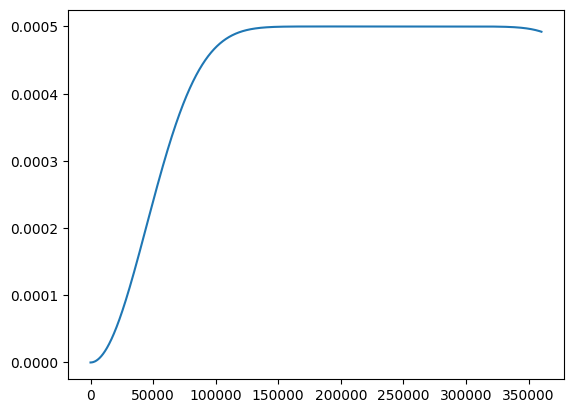

In [11]:
plt.plot(learning_rates)

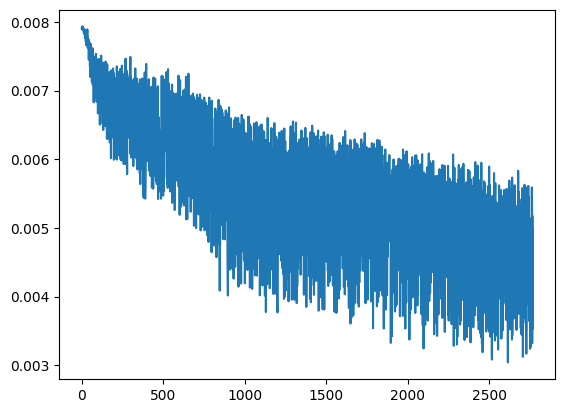

In [12]:
plt.plot(train_losses[50:])

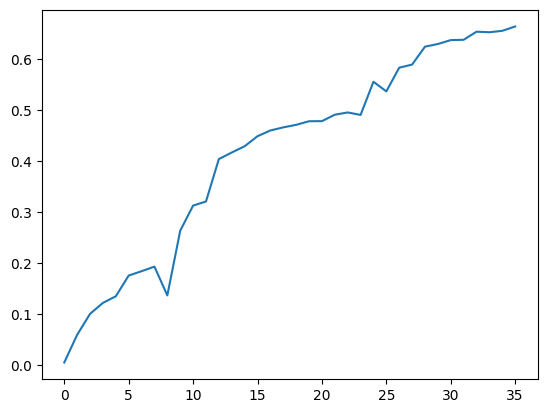

In [13]:
plt.plot(valid_accs)